# GPU-accelerated Filtered Backprojection

Using Astra.

In [1]:
# Import relevant packages

from __future__ import division
from os import mkdir
from os.path import join, isdir
from imageio import get_writer
 
import astra
import numpy as np
from tifffile import imsave
from skimage import io
import matplotlib.pyplot as plt

# Timing
from tqdm import tqdm
import time

# Garbage collection
import gc

import sys
sys.path.append('../')
from Srayan_autoalign import srayan_autoalign

Code starts here

Reconstruction of our image from 2D geometry

In [19]:
# del im
# del reconstruction_fbp
gc.collect()

# PATH_TO_IMAGE =  'embryo_stack.tif'
# PATH_TO_IMAGE = r'D:\MSci_Project\1_Data\2023-02-10 10pc 15um 3d phantom\2023-02-10 10pc 15um 3d phantom fa 400proj\1_1\1_1_MMStack_Pos0.ome.tif'
PATH_TO_IMAGE = r'D:\MSci_Project\1_Data\2023-02-20 10pc 15um 3d phantom fd 2000proj\MMStack_Pos0.ome.tif'
im = io.imread(PATH_TO_IMAGE)
print(im.shape)
print(type(im))
#srayan_autoalign.plot_alignment(im)

# Crop image to centre the centre of the image on the rotation axis
im = im[::8,:,:-8]
im.shape

(2000, 1392, 1040)
<class 'numpy.ndarray'>


(250, 1392, 1032)

In [20]:
# im = srayan_autoalign.apply_offset(im)

In [21]:
# Turn into sinogram
im = np.moveaxis(im, 0, -2).astype('float64')
print(im.shape)

# Preallocate Memory
reconstruction_fbp = np.zeros((im.shape[0], im.shape[2], im.shape[2]))

(1392, 250, 1032)


This code reconstructs the image. 

First time running set `maximum_value = 65535`.

In [24]:
# Configuration.
num_of_projections = 250
output_dir = '250proj_aligned'
maximum_value =  11216 #65535
save_reconstruction = True

# Infer parameters from inputs
detector_rows = im.shape[0]  # Vertical size of detector [pixels].
detector_cols = im.shape[-1]  # Horizontal size of detector [pixels].
angles = np.linspace(0, 2 * np.pi, num=num_of_projections, endpoint=False)

start = time.time()
for i in tqdm(range(im.shape[0])):
    # Copy projection images into ASTRA Toolbox.
    proj_geom = \
      astra.create_proj_geom('parallel', 1.0, detector_cols, angles)
    projections_id = astra.data2d.create('-sino', proj_geom, im[i])

    # Create reconstruction.
    vol_geom = astra.creators.create_vol_geom(detector_cols, detector_cols,
                                              detector_rows)
    reconstruction_id = astra.data2d.create('-vol', vol_geom, data=0)
    alg_cfg = astra.astra_dict('FBP_CUDA')
    alg_cfg['ProjectionDataId'] = projections_id
    alg_cfg['ReconstructionDataId'] = reconstruction_id
    algorithm_id = astra.algorithm.create(alg_cfg)
    astra.algorithm.run(algorithm_id)
    reconstruction = astra.data2d.get(reconstruction_id)

    # Limit and scale reconstruction.
    reconstruction[reconstruction < 0] = 0
    reconstruction /= maximum_value
    reconstruction = np.round(reconstruction * 65535).astype(np.uint16)

    # Save reconstruction.
    if save_reconstruction: 
        if not isdir(output_dir):
            mkdir(output_dir)
        #for i in range(detector_rows):
            #im = reconstruction[i, :, :]
            #im = np.flipud(im)
        imsave(join(output_dir, 'reco%04d.tif' % i), reconstruction)
    
    # Save reconstruction to preallocated memory
    reconstruction_fbp[i] = reconstruction
    
    # Cleanup.
    astra.algorithm.delete(algorithm_id)
    astra.data2d.delete(reconstruction_id)
    astra.data2d.delete(projections_id)

end = time.time()
print(end-start)

#plt.imshow(reconstruction)

100%|██████████████████████████████████████████████████████████████████████████████| 1392/1392 [00:51<00:00, 27.23it/s]

51.123481035232544


In [25]:
np.max(reconstruction_fbp)

65533.0

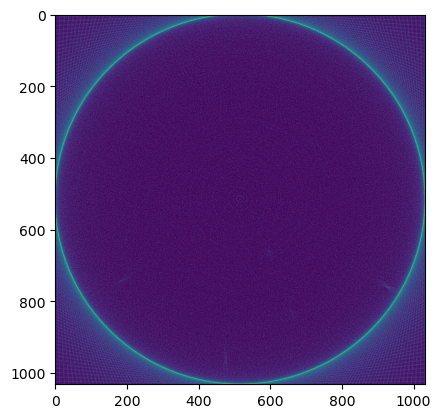

In [26]:
plt.imshow(reconstruction_fbp[0]) #696

3. Comparison with the performance of the 'iradon' function in skimage

In [ ]:
# from skimage.transform import iradon
# start = time.time()
# skimage_output = iradon(np.moveaxis(im[400],0,1), theta=angles*180/np.pi, filter_name='ramp')
# end = time.time()
# print(end-start)
# skimage_output[skimage_output < 0] = 0
# plt.imshow(skimage_output)

In [ ]:
# 3.86/0.0156